# Keypoint Detection Mini Project

#### You can get the dataset from https://www.kaggle.com/greysky/pencil-dataset

In [ ]:
! pip install -q --upgrade albumentations
! pip install "opencv-python-headless<4.3"

import os, glob, json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A

     |████████████████████████████████| 102 kB 15.2 MB/s 
     |████████████████████████████████| 47.7 MB 1.2 MB/s 
     |████████████████████████████████| 21.6 MB 1.3 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.62
    Uninstalling opencv-python-headless-4.5.5.62:
      Successfully uninstalled opencv-python-headless-4.5.5.62


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 50
BATCH_SIZE = 8

### Model Architecture

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(3, 32, 5, 4, 2),          # (n, 3, 128, 128) => (n, 32, 32, 32)
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                 # (n, 32, 32, 32) => (n, 32, 16, 16)
        nn.Conv2d(32, 64, 3, 1, 1),         # (n, 32, 16, 16) => (n, 64, 16, 16)
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                 # (n, 64, 16, 16) => (n, 64, 8, 8)
        nn.Conv2d(64, 128, 3, 1, 1),        # (n, 64, 8, 8) => (n, 128, 8, 8)
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),                 # (n, 128, 8, 8) => (n, 128, 4, 4)
        nn.Flatten(),                       # (n, 128, 4, 4) => (n, 2048)
        nn.Linear(2048, 256),               # (n, 2048) => (n, 128)
        nn.ReLU(),
        nn.Linear(256, 8),                  # (n, 128) => (n, 8)
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

### Custom Dataset

In [ ]:
class PencilDataset(Dataset):
  def __init__(self, root, transform=None):
    super().__init__()
    self.root = root
    self.classes = ['red_head', 'red_tail', 'green_head', 'green_tail']
    self.img_paths = glob.glob(f"{root}/*.jpg")
    self.transform = transform

  def __len__(self):
    return len(self.img_paths)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    image = Image.open(img_path)
    target = self.json_to_keypoints(img_path.replace('.jpg', '.json'))

    if self.transform:
      augmented = self.transform(image=np.array(image), keypoints=target)
      image, target = augmented['image'], augmented['keypoints']
      image, target = torch.from_numpy(image), torch.tensor(target)

      target[:, 0] = target[:, 0] / image.shape[0]
      target[:, 1] = target[:, 1] / image.shape[1]
      target[(1 < target[:, 0]) | (0 > target[:, 0]) | (1 < target[:, 1]) | (0 > target[:, 1])] = 0
    
    image = image.permute(2, 0, 1)
    image = image / 255.0
    target = target.reshape(-1)
    
    return image, target

  def json_to_keypoints(self, json_path):
    with open(json_path, 'r') as f:
      dj = json.load(f)

      keypoints = [(0, 0), (0, 0), (0, 0), (0, 0)]
      
      for obj in dj['objects']:
        if obj['category'] == 'red_pencil':
          keypoints[0] = (obj['keypoints'][0], obj['keypoints'][1])
          keypoints[1] = (obj['keypoints'][2], obj['keypoints'][3])
        else:
          keypoints[2] = (obj['keypoints'][0], obj['keypoints'][1])
          keypoints[3] = (obj['keypoints'][2], obj['keypoints'][3])

    return keypoints

### Plot Function

In [ ]:
def plot_images(data_iter, n_samples):
  imgs, targets = next(data_iter)
  fig, axes = plt.subplots(1, n_samples, figsize=(20, 6))

  for img, target, ax in zip(imgs, targets, axes):
    ax.axis("off")
    ax.imshow(img.permute(1, 2, 0))
    
    if(all(target[0:2] != 0)):
      ax.add_patch(patches.Circle([target[0] * img.shape[1], target[1] * img.shape[2]], color='r'))
    if(all(target[2:4] != 0)):
      ax.add_patch(patches.Circle([target[2] * img.shape[1], target[3] * img.shape[2]], color='r'))    
    if(all(target[4:6] != 0)):
      ax.add_patch(patches.Circle([target[4] * img.shape[1], target[5] * img.shape[2]], color='b'))
    if(all(target[6:8] != 0)):
      ax.add_patch(patches.Circle([target[6] * img.shape[1], target[7] * img.shape[2]], color='b'))

### Transforms

In [ ]:
train_transform = A.Compose([
    A.RandomCrop(height=800, width=800),
    A.RandomRotate90(p=1.0),
    A.Resize(height=128, width=128),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

valid_transform = A.Compose([
    A.CenterCrop(height=800, width=800),
    A.Resize(height=128, width=128),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

test_transform = A.Compose([
    A.CenterCrop(height=800, width=800),
    A.Resize(height=128, width=128),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

### Dataset Initialization

In [ ]:
train_set = PencilDataset('dataset/train', transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
train_iter = iter(train_loader)

valid_set = PencilDataset('dataset/valid', transform=valid_transform)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=True)
valid_iter = iter(valid_loader)

test_set = PencilDataset('dataset/test', transform=test_transform)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)
test_iter = iter(test_loader)

### Train Samples

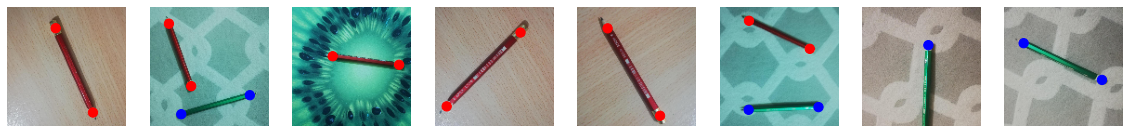

In [ ]:
plot_images(train_iter, 8)

### Valid Samples

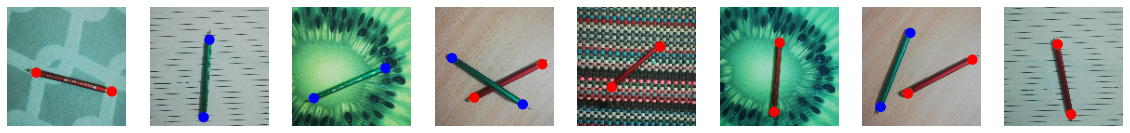

In [ ]:
plot_images(valid_iter, 8)

### Test Samples

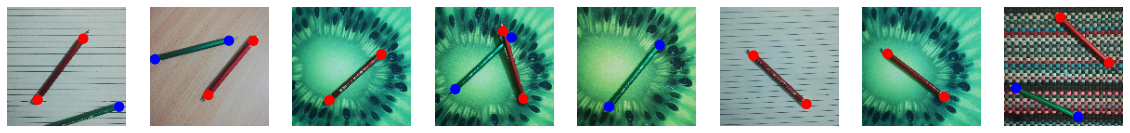

In [ ]:
plot_images(test_iter, 8)

### Model Initialization

In [ ]:
model = Net().to(DEVICE)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

### Train Function

In [ ]:
def train_fn(loader, model, optimizer, loss_fn):
  total_loss = 0.0
  model.train()

  for batch_idx, (x, y) in enumerate(loader):
    x, y = x.to(DEVICE), y.to(DEVICE)
    x, y = x.float(), y.float()

    pred_y = model(x)
    loss = loss_fn(pred_y, y)
    total_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return (total_loss / len(loader))

### Validation Function

In [ ]:
def valid_fn(loader, model, loss_fn):
  total_loss = 0.0
  model.eval()

  with torch.no_grad(): 
    for batch_idx, (x, y) in enumerate(loader):
      x, y = x.to(DEVICE), y.to(DEVICE)

      pred_y = model(x)
      total_loss += loss_fn(pred_y, y).item()
    
    return (total_loss / len(loader))

### Training

In [ ]:
train_y, valid_y = [], []
min_loss = 100.0

for i in range(NUM_EPOCHS):
  loss = train_fn(train_loader, model, optimizer, criterion)
  train_y.append(loss)

  vloss = valid_fn(valid_loader, model, criterion)
  valid_y.append(vloss)
  
  print('{0}.loss: {1:.4f}    vloss: {2:.4f}'.format(i + 1, loss, vloss))

  if (vloss < min_loss):
    min_loss = vloss
    torch.save(model.state_dict(), 'model.data')

1.loss: 0.0414    vloss: 0.0443
2.loss: 0.0430    vloss: 0.0404
3.loss: 0.0445    vloss: 0.0498
4.loss: 0.0449    vloss: 0.0467
5.loss: 0.0468    vloss: 0.0435
6.loss: 0.0421    vloss: 0.0440
7.loss: 0.0385    vloss: 0.0447
8.loss: 0.0440    vloss: 0.0451
9.loss: 0.0408    vloss: 0.0447
10.loss: 0.0434    vloss: 0.0472
11.loss: 0.0388    vloss: 0.0447
12.loss: 0.0418    vloss: 0.0430
13.loss: 0.0414    vloss: 0.0445
14.loss: 0.0376    vloss: 0.0454
15.loss: 0.0382    vloss: 0.0453
16.loss: 0.0391    vloss: 0.0439
17.loss: 0.0387    vloss: 0.0432
18.loss: 0.0409    vloss: 0.0415
19.loss: 0.0417    vloss: 0.0403
20.loss: 0.0401    vloss: 0.0393
21.loss: 0.0379    vloss: 0.0400
22.loss: 0.0434    vloss: 0.0458
23.loss: 0.0398    vloss: 0.0451
24.loss: 0.0404    vloss: 0.0433
25.loss: 0.0381    vloss: 0.0439
26.loss: 0.0404    vloss: 0.0417
27.loss: 0.0363    vloss: 0.0402
28.loss: 0.0380    vloss: 0.0435
29.loss: 0.0377    vloss: 0.0418
30.loss: 0.0362    vloss: 0.0373
31.loss: 0.0399    

### Loss Graph

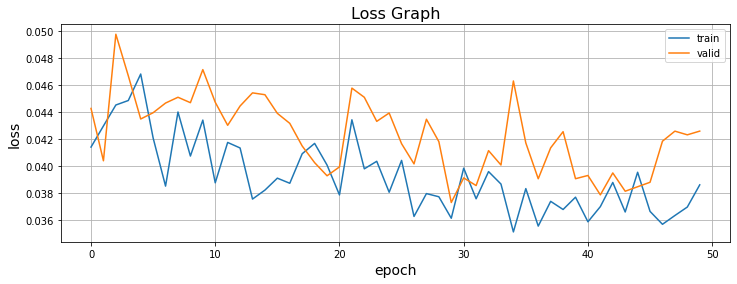

In [ ]:
plt.rcParams["figure.figsize"] = (12, 4)

plt.title('Loss Graph', fontsize=16)
plt.xlabel('epoch', fontsize=14)
plt.ylabel('loss', fontsize=14)

plt.plot(train_y)
plt.plot(valid_y)
plt.legend(['train', 'valid'])
plt.grid()

plt.show()

### Plot Function

In [ ]:
def plot_predictions(data_iter, model, n_samples):
  imgs, targets = next(data_iter)

  model.eval()
  with torch.no_grad():
    preds = model(imgs.to(DEVICE)).to('cpu')

  fig, axes = plt.subplots(1, n_samples, figsize=(20, 6))

  for img, pred, ax in zip(imgs, preds, axes):
    ax.axis("off")
    ax.imshow(img.permute(1, 2, 0))

    if(all(pred[0:2] > 0.01)):
      ax.add_patch(patches.Circle([pred[0] * img.shape[1], pred[1] * img.shape[2]], color='r'))
    if(all(pred[2:4] > 0.01)):
      ax.add_patch(patches.Circle([pred[2] * img.shape[1], pred[3] * img.shape[2]], color='r'))    
    if(all(pred[4:6] > 0.01)):
      ax.add_patch(patches.Circle([pred[4] * img.shape[1], pred[5] * img.shape[2]], color='b'))
    if(all(pred[6:8] > 0.01)):
      ax.add_patch(patches.Circle([pred[6] * img.shape[1], pred[7] * img.shape[2]], color='b'))

### Testing (yeah it sucks)

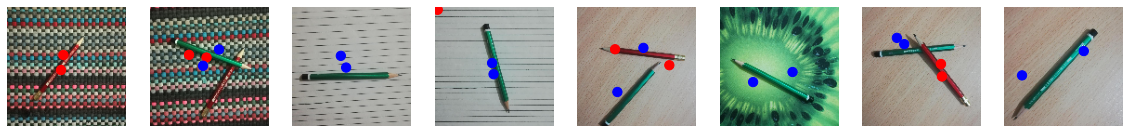

In [ ]:
plot_predictions(test_iter, model, 8)